In [1]:
import pandas as pd
import numpy as np


In [2]:
df_his=pd.read_csv('/home/amitdubey/Downloads/historical_data.csv')
df_fg=pd.read_csv('/home/amitdubey/Downloads/fear_greed_index.csv')

In [3]:
df_his.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
df_fg.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


SHAPE

In [5]:
print("df_his shape: ",df_his.shape)
print("df_fg shape: ",df_fg.shape) 

df_his shape:  (211224, 16)
df_fg shape:  (2644, 4)


null values

In [6]:
print("df_his :\n",df_his.isnull().sum())
print(" \n df_fg :\n",df_his.isnull().sum())

df_his :
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
 
 df_fg :
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Duplicates

In [7]:
print('Duplicates df his:', df_his.duplicated().sum())
print('Duplicates df fg:', df_fg.duplicated().sum())

Duplicates df his: 0
Duplicates df fg: 0


Convert timestamps and align the datasets by date (daily)

In [8]:
df_his['date'] = pd.to_datetime(df_his['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.normalize()
df_fg['date'] = pd.to_datetime(df_fg['date'], errors='coerce').dt.normalize()


check min max dates

In [9]:
print("df_his",df_his['date'].min(), df_his['date'].max())
print("df_fg",df_fg['date'].min(), df_fg['date'].max())

df_his 2023-05-01 00:00:00 2025-05-01 00:00:00
df_fg 2018-02-01 00:00:00 2025-05-02 00:00:00


merge the dataframe

In [10]:
df_merged = df_his.merge(
    df_fg[['date', 'value', 'classification']],
    on='date',
    how='left'
)


In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [12]:
col=[
    'Account', 'Coin', 'Timestamp', 'date',
    'Side', 'Size USD', 'Closed PnL', 'Fee',
    'value', 'classification',
]
df_merge= df_merged[col]

In [13]:

# 1) win column
df_merge['win'] = df_merge['Closed PnL'] > 0

# 2) daily metrics per trader
daily_metrics = df_merge.groupby(['date', 'Account']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    win_rate=('win', 'mean'),
    avg_trade_size=('Size USD', 'mean'),
    num_trades=('Closed PnL', 'count'),
    buy_trades=('Side', lambda x: (x == 'BUY').sum()),
    sell_trades=('Side', lambda x: (x == 'SELL').sum())
).reset_index()

# 3) long/short ratio
daily_metrics['long_short_ratio'] = (
    daily_metrics['buy_trades'] / daily_metrics['sell_trades'].replace(0, np.nan)
)

# 4) merge back into df_merge (adds as columns)
df_merge = df_merge.merge(
    daily_metrics[['date','Account','daily_pnl','win_rate','avg_trade_size',
                   'num_trades','long_short_ratio']],
    on=['date','Account'],
    how='left'
)

df_merge.head()

/tmp/ipykernel_111096/1170131065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['win'] = df_merge['Closed PnL'] > 0


,Account,Coin,Timestamp,date,Side,Size USD,Closed PnL,Fee,value,classification,win,daily_pnl,win_rate,avg_trade_size,num_trades,long_short_ratio
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1.730000e+12,2024-12-02,BUY,7872.16,0.0,0.345404,80.0,Extreme Greed,False,0.0,0.0,1779.029545,44,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1.730000e+12,2024-12-02,BUY,127.68,0.0,0.005600,80.0,Extreme Greed,False,0.0,0.0,1779.029545,44,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1.730000e+12,2024-12-02,BUY,1150.63,0.0,0.050431,80.0,Extreme Greed,False,0.0,0.0,1779.029545,44,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1.730000e+12,2024-12-02,BUY,1142.04,0.0,0.050043,80.0,Extreme Greed,False,0.0,0.0,1779.029545,44,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1.730000e+12,2024-12-02,BUY,69.75,0.0,0.003055,80.0,Extreme Greed,False,0.0,0.0,1779.029545,44,NaN


Number of trades per day

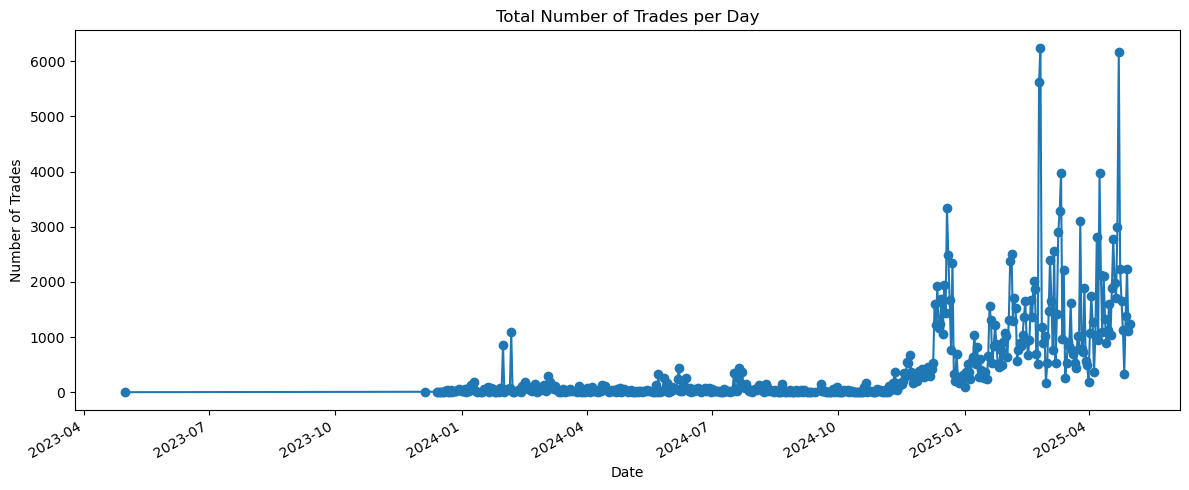

In [14]:
trades_per_day = df_merge.groupby('date').size()
trades_per_day.plot(kind='line', marker='o', figsize=(12, 5))
plt.title('Total Number of Trades per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.tight_layout()
plt.show()

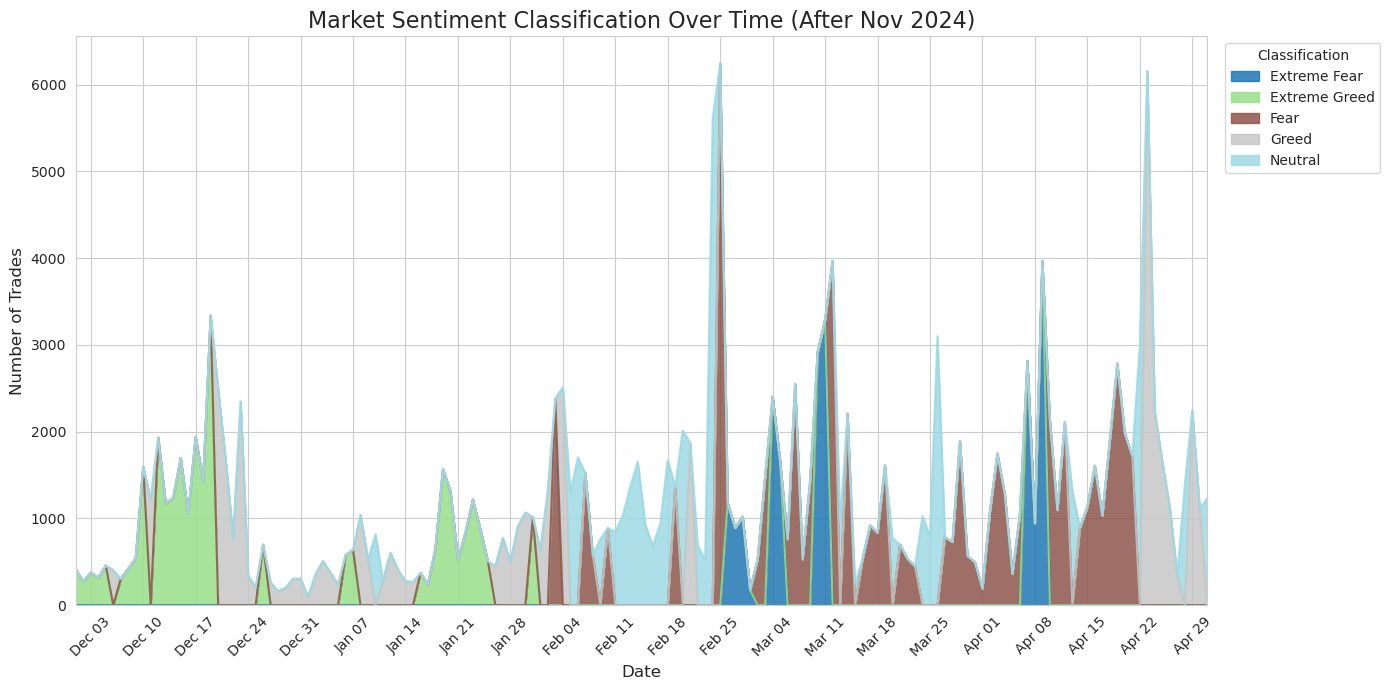

In [15]:
# Better visualization: use seaborn for a cleaner look and highlight trends
import matplotlib.dates as mdates

filtered_df = df_merge[df_merge['date'] > pd.to_datetime('2024-11-30')]
classification_counts = filtered_df.groupby(['date', 'classification']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
sns.set_style('whitegrid')
classification_counts = classification_counts.resample('D').sum() if isinstance(classification_counts.index, pd.DatetimeIndex) else classification_counts
classification_counts.plot(kind='area', stacked=True, colormap='tab20', alpha=0.85, ax=plt.gca())
plt.title('Market Sentiment Classification Over Time (After Nov 2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Trades', fontsize=12)
plt.legend(title='Classification', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

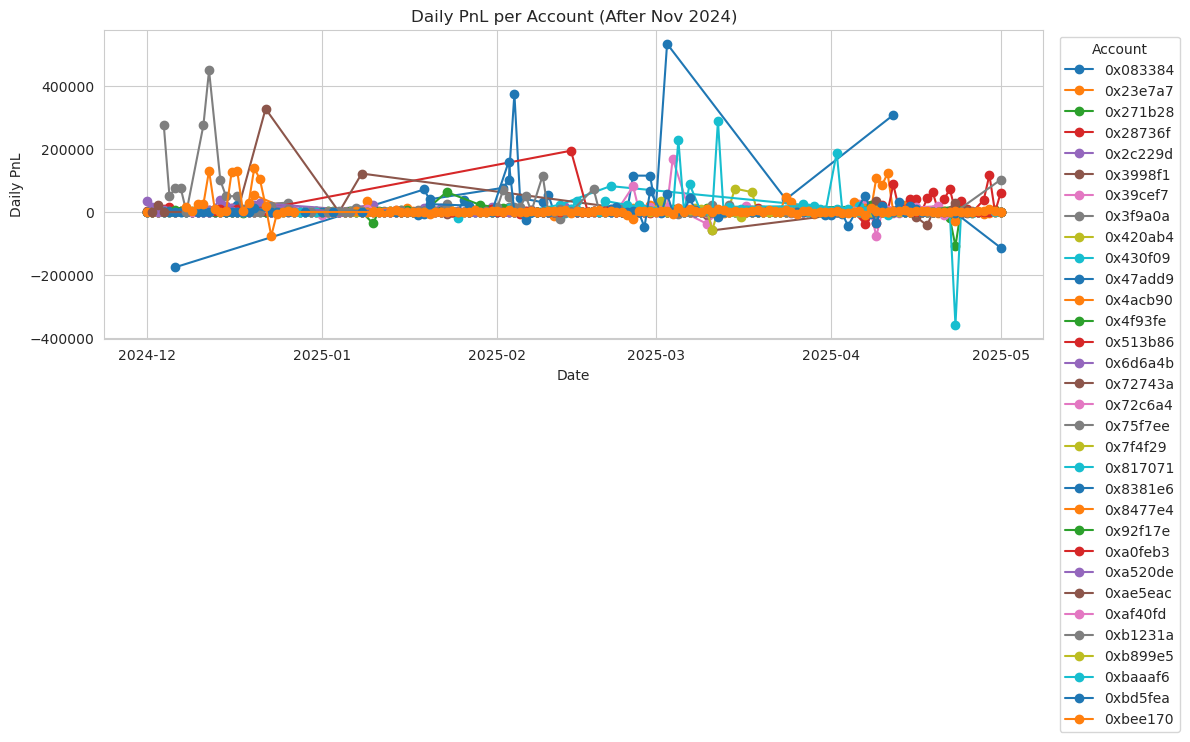

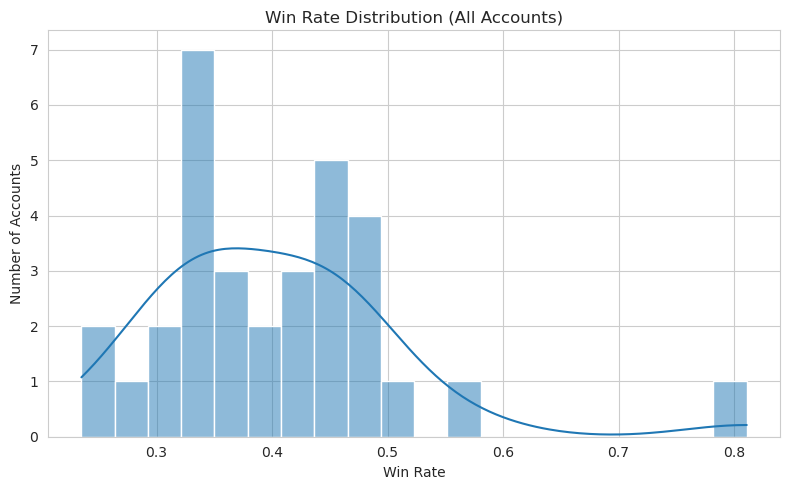

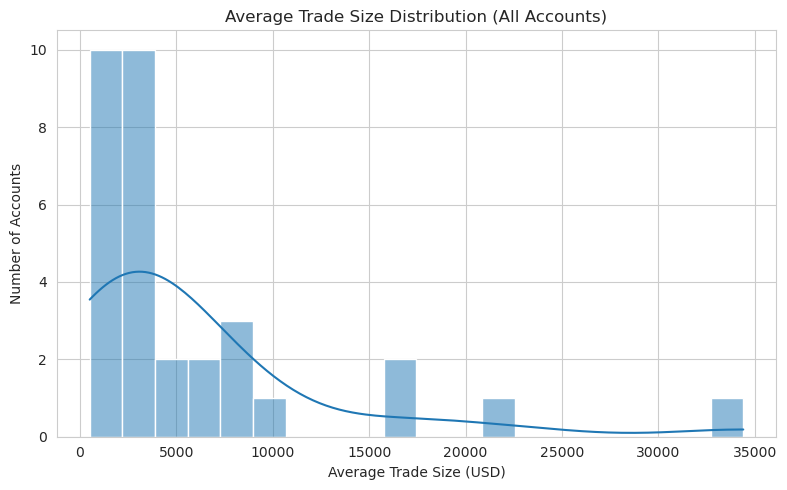

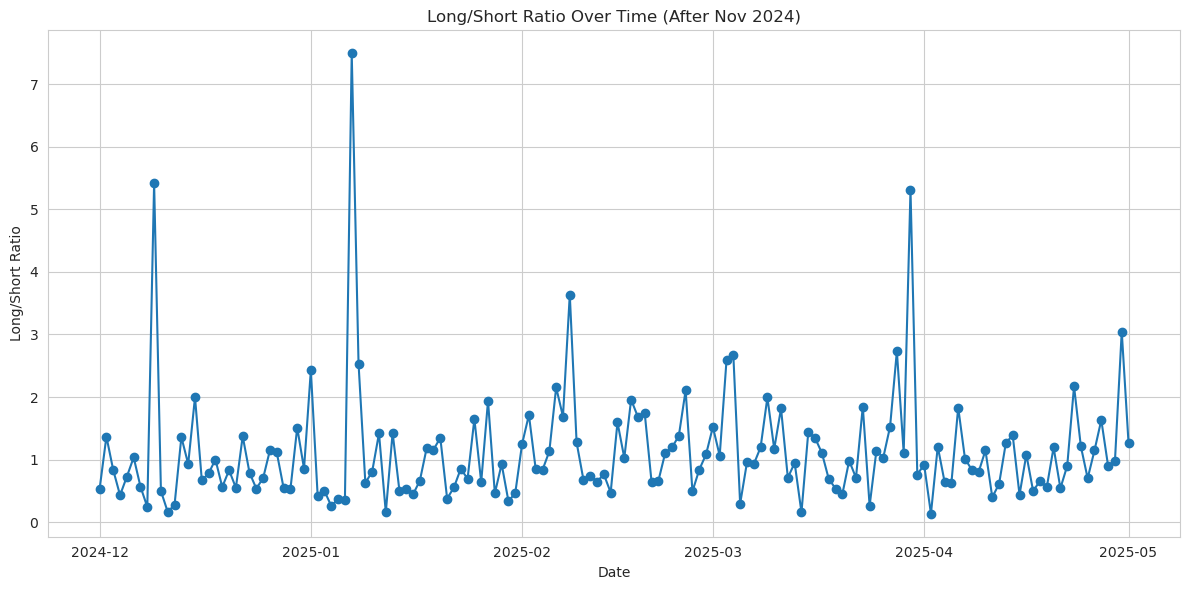

In [19]:
# Ensure metrics are recalculated if not present
if 'pnl_per_day' not in globals():
    pnl_per_day = df_merge.groupby(['date', 'Account'])['Closed PnL'].sum().reset_index(name='daily_pnl')
if 'win_rate' not in globals():
    win_trades = df_merge['Closed PnL'] > 0
    win_rate = df_merge[win_trades].groupby('Account').size() / df_merge.groupby('Account').size()
    win_rate = win_rate.reset_index(name='win_rate')
if 'avg_trade_size' not in globals():
    avg_trade_size = df_merge.groupby('Account')['Size USD'].mean().reset_index(name='avg_trade_size')
if 'long_short' not in globals():
    long_short = df_merge.groupby(['date', 'Side']).size().unstack(fill_value=0)
    if 'BUY' in long_short.columns and 'SELL' in long_short.columns:
        long_short['long_short_ratio'] = long_short['BUY'] / (long_short['SELL'].replace(0, np.nan))
    else:
        long_short['long_short_ratio'] = np.nan

# 1. Daily PnL per account (after Nov 2024)
plt.figure(figsize=(12,6))
for acc, grp in pnl_per_day[pnl_per_day['date'] > pd.to_datetime('2024-11-30')].groupby('Account'):
    plt.plot(grp['date'], grp['daily_pnl'], marker='o', label=str(acc)[:8])
plt.title('Daily PnL per Account (After Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Daily PnL')
plt.legend(title='Account', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Win rate distribution (bar plot)
plt.figure(figsize=(8,5))
sns.histplot(win_rate['win_rate'], bins=20, kde=True)
plt.title('Win Rate Distribution (All Accounts)')
plt.xlabel('Win Rate')
plt.ylabel('Number of Accounts')
plt.tight_layout()
plt.show()

# 3. Average trade size distribution
plt.figure(figsize=(8,5))
sns.histplot(avg_trade_size['avg_trade_size'], bins=20, kde=True)
plt.title('Average Trade Size Distribution (All Accounts)')
plt.xlabel('Average Trade Size (USD)')
plt.ylabel('Number of Accounts')
plt.tight_layout()
plt.show()

# 4. Long/Short ratio over time (after Nov 2024)
plt.figure(figsize=(12,6))
ls = long_short[long_short.index > pd.to_datetime('2024-11-30')]
plt.plot(ls.index, ls['long_short_ratio'], marker='o')
plt.title('Long/Short Ratio Over Time (After Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Long/Short Ratio')
plt.tight_layout()
plt.show() 